# Sentiment analysis

### Import libraries

In [1]:
import re
import logging
import numpy as np
import pandas as pd
import multiprocessing
import matplotlib.pyplot as plt

from re import sub
from time import time 
from unidecode import unidecode
from gensim.models import Word2Vec
from collections import defaultdict
from gensim.models import KeyedVectors
from gensim.test.utils import get_tmpfile
from gensim.models.phrases import Phrases, Phraser

from sklearn.cluster import KMeans
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score

logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)


### Load data

In [2]:
df_combined = pd.read_csv('data/sentiment/combined_preprocessed_comments.csv')
df_cleaned = df_combined.dropna().drop_duplicates().reset_index(drop=True)

### Text to word list function

In [3]:
def text_to_word_list(text, remove_polish_letters):
    ''' Pre process and convert texts to a list of words 
    method inspired by method from eliorc github repo: https://github.com/eliorc/Medium/blob/master/MaLSTM.ipynb'''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text)
    text = sub(r"\+", " plus ", text)
    text = sub(r",", " ", text)
    text = sub(r"\.", " ", text)
    text = sub(r"!", " ! ", text)
    text = sub(r"\?", " ? ", text)
    text = sub(r"'", " ", text)
    text = sub(r":", " : ", text)
    text = sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

df_cleaned['comment_no_stopwords_list'] = df_cleaned['comment_no_stopwords'].apply(lambda x: text_to_word_list(x, unidecode))
df_cleaned['comment_no_stopwords'] = df_cleaned['comment_no_stopwords'].apply(lambda x: text_to_word_list(x, unidecode))
df_model = df_cleaned.copy()

### Creation of bigrams for co-occuring words

In [4]:
sent = [row for row in df_model['comment_no_stopwords']]
phrases = Phrases(sent, min_count=1, progress_per=50000)
bigram = Phraser(phrases)
sentences = bigram[sent]
sentences[1]

INFO - 19:11:42: collecting all words and their counts
INFO - 19:11:42: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 19:11:42: collected 208185 token types (unigram + bigrams) from a corpus of 257100 words and 13314 sentences
INFO - 19:11:42: merged Phrases<208185 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
INFO - 19:11:42: Phrases lifecycle event {'msg': 'built Phrases<208185 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.39s', 'datetime': '2024-12-06T19:11:42.564366', 'gensim': '4.3.3', 'python': '3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'created'}
INFO - 19:11:42: exporting phrases from Phrases<208185 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
INFO - 19:11:42: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<10504 phrases, min_count=1, threshold=10.0> from Phrases<208185 vocab, min_count=1, threshold=1

['protest',
 'non_voters',
 'worst',
 'type',
 'privileged',
 'people',
 'believing',
 'allowing',
 'worse',
 'outcome',
 'single_issue',
 'get',
 'worse',
 'non',
 'vote',
 'exact_opposite',
 'trying_help',
 'because']

### Word2Vec model

In [5]:
w2v_model = Word2Vec(min_count=3,
                     window=4,
                     vector_size=300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=multiprocessing.cpu_count()-1)

start = time()

w2v_model.build_vocab(sentences, progress_per=50000)

print('Vocab creation time: {} mins'.format(round((time() - start) / 60, 2)))

INFO - 19:11:42: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.03>', 'datetime': '2024-12-06T19:11:42.993046', 'gensim': '4.3.3', 'python': '3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'created'}
INFO - 19:11:42: collecting all words and their counts
INFO - 19:11:43: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 19:11:43: collected 30215 word types from a corpus of 223065 raw words and 13314 sentences
INFO - 19:11:43: Creating a fresh vocabulary
INFO - 19:11:43: Word2Vec lifecycle event {'msg': 'effective_min_count=3 retains 11537 unique words (38.18% of original 30215, drops 18678)', 'datetime': '2024-12-06T19:11:43.335439', 'gensim': '4.3.3', 'python': '3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'prepare_vocab'}
INFO - 19:11:43: Word2Vec lifecy

Vocab creation time: 0.01 mins


### Training

In [6]:
start = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - start) / 60, 2)))

w2v_model.init_sims(replace=True)

INFO - 19:11:43: Word2Vec lifecycle event {'msg': 'training model with 7 workers on 11537 vocabulary and 300 features, using sg=0 hs=0 sample=1e-05 negative=20 window=4 shrink_windows=True', 'datetime': '2024-12-06T19:11:43.577336', 'gensim': '4.3.3', 'python': '3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'train'}
INFO - 19:11:43: EPOCH 0: training on 223065 raw words (68495 effective words) took 0.4s, 194981 effective words/s
INFO - 19:11:44: EPOCH 1: training on 223065 raw words (68584 effective words) took 0.3s, 213226 effective words/s
INFO - 19:11:44: EPOCH 2: training on 223065 raw words (68563 effective words) took 0.3s, 207687 effective words/s
INFO - 19:11:45: EPOCH 3: training on 223065 raw words (68464 effective words) took 0.4s, 171212 effective words/s
INFO - 19:11:45: EPOCH 4: training on 223065 raw words (68485 effective words) took 0.3s, 212885 effective words/s
INFO - 19:11:45: E

Time to train the model: 0.17 mins


In [7]:
w2v_model.save("data/sentiment/word2vec.model")

INFO - 19:11:53: Word2Vec lifecycle event {'fname_or_handle': 'data/sentiment/word2vec.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2024-12-06T19:11:53.934612', 'gensim': '4.3.3', 'python': '3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'saving'}
INFO - 19:11:53: not storing attribute cum_table
INFO - 19:11:53: saved data/sentiment/word2vec.model


### Applying co-occurence to data

In [8]:
df_model_export = df_model.copy()
df_model_export['old_comment_no_stopwords'] = df_model_export['comment_no_stopwords']
df_model_export.old_comment_no_stopwords = df_model_export.old_comment_no_stopwords.str.join(' ')
df_model_export['comment_no_stopwords'] = df_model_export['comment_no_stopwords'].apply(lambda x: ' '.join(bigram[x]))

df_model_export.to_csv("data/sentiment/cleaned_comments_preprocessed.csv", index=False)

In [9]:
word_vectors = Word2Vec.load("data/sentiment/word2vec.model").wv

INFO - 19:11:54: loading Word2Vec object from data/sentiment/word2vec.model
INFO - 19:11:54: loading wv recursively from data/sentiment/word2vec.model.wv.* with mmap=None
INFO - 19:11:54: setting ignored attribute cum_table to None
INFO - 19:11:54: Word2Vec lifecycle event {'fname': 'data/sentiment/word2vec.model', 'datetime': '2024-12-06T19:11:54.740779', 'gensim': '4.3.3', 'python': '3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'loaded'}


### Elbow method and Silhouette score for K-means clustering

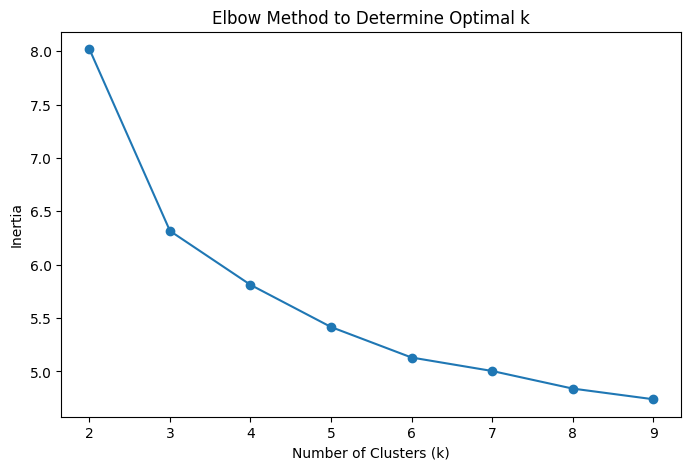

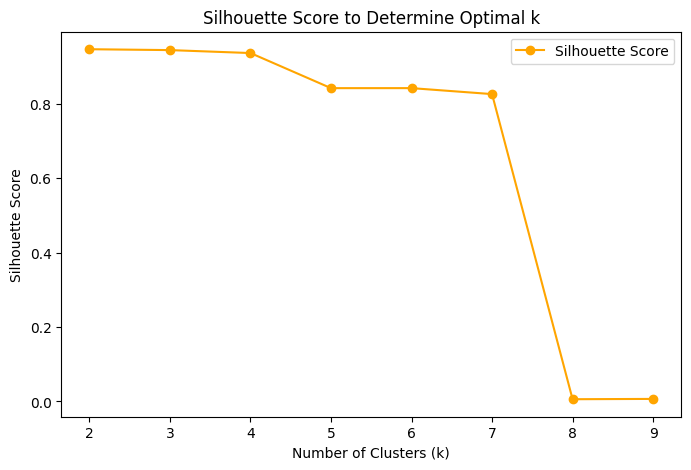

In [10]:
# Range of k clusters
k_values = range(2, 10)
inertia = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X=word_vectors.vectors.astype('double')) 
    inertia.append(kmeans.inertia_)

    # Compute silhouette score
    labels = kmeans.labels_
    silhouette = silhouette_score(word_vectors.vectors.astype('double'), labels)
    silhouette_scores.append(silhouette)

# Plot inertia vs. k
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal k')
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', color='orange', label='Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score to Determine Optimal k')
plt.legend()
plt.show()

In [11]:
silhouette_scores

[0.9469496816642426,
 0.9445768609159109,
 0.9366476877315953,
 0.8422755290341831,
 0.842339417256956,
 0.826290988897639,
 0.0058808286530081764,
 0.00672201352455328]

In [12]:
for k in range(len(k_values)):
    print(f"Silhoutte score for {k+2} clusters: {silhouette_scores[k]}")

Silhoutte score for 2 clusters: 0.9469496816642426
Silhoutte score for 3 clusters: 0.9445768609159109
Silhoutte score for 4 clusters: 0.9366476877315953
Silhoutte score for 5 clusters: 0.8422755290341831
Silhoutte score for 6 clusters: 0.842339417256956
Silhoutte score for 7 clusters: 0.826290988897639
Silhoutte score for 8 clusters: 0.0058808286530081764
Silhoutte score for 9 clusters: 0.00672201352455328


### Define and fit KMeans model

In [13]:
model = KMeans(n_clusters=5, max_iter=1000, random_state=True, n_init=50).fit(X=word_vectors.vectors.astype('double'))

In [14]:
word_vectors.similar_by_vector(model.cluster_centers_[4], topn=50, restrict_vocab=None)

[('bullets', 0.9998773336410522),
 ('emerged', 0.9998766779899597),
 ('pappe', 0.9998766779899597),
 ('chance', 0.999875545501709),
 ('releases', 0.9998741149902344),
 ('expert', 0.9998741149902344),
 ('upload', 0.9998738765716553),
 ('recognizing', 0.9998738169670105),
 ('president_biden', 0.9998733401298523),
 ('hoping', 0.9998728036880493),
 ('stupid', 0.9998718500137329),
 ('anywhere', 0.9998708963394165),
 ('1994', 0.9998704195022583),
 ('next_month', 0.9998703002929688),
 ('sit', 0.9998701810836792),
 ('space', 0.9998700022697449),
 ('joe', 0.9998699426651001),
 ('source', 0.9998697638511658),
 ('foreign_military', 0.999869704246521),
 ('business_usual', 0.9998695254325867),
 ('wealthy_country', 0.9998693466186523),
 ('karta', 0.9998692274093628),
 ('easier', 0.9998692274093628),
 ('refuse', 0.999869167804718),
 ('malaysia', 0.9998689889907837),
 ('lack', 0.9998687505722046),
 ('spirit', 0.999868631362915),
 ('treated', 0.9998685121536255),
 ('fighting_terrorists', 0.999868452548

In [15]:
positive_cluster_index = 0
positive_cluster_center = model.cluster_centers_[positive_cluster_index]
negative_cluster_center = model.cluster_centers_[1-positive_cluster_index]

In [16]:
words = pd.DataFrame(word_vectors.index_to_key)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])

In [17]:
words['cluster_value'] = [1 if i==positive_cluster_index else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value

In [18]:
words[['words', 'sentiment_coeff']].to_csv('data/sentiment/sentiment_dictionary.csv', index=False)

In [19]:
sentiment_map = pd.read_csv('data/sentiment/sentiment_dictionary.csv')
sentiment_dict = dict(zip(sentiment_map.words.values, sentiment_map.sentiment_coeff.values))

In [20]:
final_df = pd.read_csv("data/sentiment/cleaned_comments_preprocessed.csv")
df_weighting = final_df.copy()
df_weighting = df_weighting[df_weighting['comment_no_stopwords'].str.len()>0]
df_weighting = df_weighting.reset_index(drop=True)

tfidf = TfidfVectorizer(tokenizer=lambda y: y.split(), norm=None)
tfidf.fit(df_weighting['comment_no_stopwords'])
features = pd.Series(tfidf.get_feature_names_out())


c:\Users\danie\OneDrive - Danmarks Tekniske Universitet\Dokumenter\7. semester\Computational tools for data science\ComputationalEnv\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [21]:
missing_words =pd.Series(['every_single'])
features = pd.concat([features, missing_words]).reset_index(drop=True)
transformed = tfidf.transform(df_weighting['comment_no_stopwords'])

In [22]:
def create_tfidf_dictionary(x, transformed_file, features):
    '''
    create dictionary for each input sentence x, where each word has assigned its tfidf score
    
    inspired  by function from this wonderful article: 
    https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34
    
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer

    '''
    vector_coo = transformed_file[x.name].tocoo()
    words = features.iloc[vector_coo.col].values
    dict_from_coo = dict(zip(vector_coo.col, vector_coo.data))
    return dict_from_coo

def replace_tfidf_words(x, transformed_file, features):
    '''
    replacing each word with it's calculated tfidf dictionary with scores of each word
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    '''
    dictionary = create_tfidf_dictionary(x, transformed_file, features)   
    return list(map(lambda y: dictionary.get(y, 0), x['comment_no_stopwords'].split()))

In [23]:
%%time
replaced_tfidf_scores = df_weighting.apply(lambda x: replace_tfidf_words(x, transformed, features), axis=1) # this step takes around 3-4 minutes minutes to calculate

CPU times: total: 1.41 s
Wall time: 2.74 s


In [24]:
def replace_sentiment_words(word, sentiment_dict):
    '''
    replacing each word with its associated sentiment score from sentiment dict
    '''
    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

In [25]:
replaced_closeness_scores = df_weighting['comment_no_stopwords'].apply(lambda x: list(map(lambda y: replace_sentiment_words(y, sentiment_dict), x.split())))

In [26]:
replacement_df = pd.DataFrame(data=[replaced_closeness_scores, replaced_tfidf_scores, df_weighting['comment_no_stopwords']]).T
replacement_df.columns = ['sentiment_coeff', 'tfidf_scores', 'sentence']
replacement_df['sentiment_rate'] = replacement_df.apply(lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']), axis=1)

In [27]:
replacement_df['sentiment_score_unsupervised'] = replacement_df['sentiment_coeff'].apply(np.mean)

In [28]:
df_final = pd.read_csv("data/sentiment/cleaned_comments_preprocessed.csv")
df_final['sentiment_score_unsupervised'] = replacement_df['sentiment_score_unsupervised']

df_final.to_csv('data/sentiment/cleaned_comments_preprocessed.csv', index=False)